# FORECASTING MONTHLY SUN SPOTS

## Overview

The sun is composed of a moving electrically charged hot gas that generates a powerful magnetic field that goes through a cycle called the __solar cycle__. A solar cycle is a cycle that the sun's magnetic field makes at approximately every 11 years. At every 11 years or so, this magnetic field flips completely with the north pole switching places with the south pole of the sun. In another 11 years, they switch back places to their original state. Solar cycle affects the activity on the Sun's surface, one of which is the sunspots which are caused by the sun's magnetic fields. As the magnetic fields change, the amount of activity on the Sun's surface does the same. 

To track the solar cycle, one way is to count the __number of sunspots__. At the beginning of a solar cycle is the solar minimum when the sun has the least sunspots. Overtime, the solar activity as well as the number of sunspots increases. At the middle of the cycle is the solar maximum where the number of sunspots are the highest and as the cycle ends, the number of sunspots fades back to the solar minimum and then a new cycle begins. Apart from the number of sunspots, other solar activities such as giant eruptions of the sun such as solar flares and coronal mass ejections also increase during the solar cycle, releasing powerful bursts of energy and material into space.

The Earth can also be affected by solar activities. For example, lights in the sky called aurora, impact on radio communications, and electricity grids. It can also cause a huge effect on satellite electronics and limit their lifespan and as well, can affect astronauts that work in International Space Stations. Some cycles can have minimums with lots of sunspots and activity while other cycles can have very few subspots and little activity. As a result of the effects of solar activity on Earth, it is important to predict the strength and duration of solar cycles. This will enable scientists forecast these solar conditions (space weather) and help them to protect radio communications on Earth, help keep satellites of space stations (eg. NASA) and keep astronauts safe by delaying their spacewalks.

In this project, we will forecast the monthly average number of sunspots for 2023. We will also forecast the average yearly sunspots for the next 11 years.

## Dataset
The [dataset](https://www.sidc.be/silso/datafiles) contains daily sunspots observed from Jan. 1818 till Dec. 2022. There are days when no sunspots were recorded; these were replaced with -1 indicating missing values.

## Data Visualisation and Analysis
In this section, we will start with some data visualisation and analysis to understand the data better. But firstly, we will import the dataset and some helper packages and libraries to aid in wrangling, analysis, and visualisation

We will look at the following research questions

### Research Questions
- What is the average yearly sunspots over time (1818-2022)?
- What is the summary statistics of monthly sunspots recorded between 1818-2022?
- What month of the year did we have the least and highest number of sunspots?
- Are there months in the year when sunspots are more?
- Is there any difference in the monthly sunspots recorded in the last 50 years?
- Forecasting average monthly sunspots for the next 12 months in 2023
- Forecasting average yearly sunspots to be observed for the next 11 years (2023-2033)

---

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from scipy import stats

In [2]:
from pmdarima.arima import auto_arima, ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
%matplotlib inline

Data Preprocessing steps
- Data Integrity: Checking for missing rows and duplicate values
- Replace -1 with np.nan to indicate missing values and drop them (From data source, we were told that -1 represents missing values)
- Create the date variable
- Selecting relevant variables

In [4]:
# variable names
names = ['year', 'month', 'day', 'date_year_frac', 'sunspot_num', 'sunspot_num_std', 'n_obs', 'status']

# import data
data = pd.read_csv('SN_d_tot_V2.0.csv', sep=';', names=names)

In [5]:
# data description
data.describe()

,year,month,day,date_year_frac,sunspot_num,sunspot_num_std,n_obs,status
count,74875.000000,74875.000000,74875.000000,74875.000000,74875.000000,74875.000000,74875.000000,74875.000000
mean,1920.000267,6.523005,15.729416,1920.500267,78.617242,6.926375,4.981008,0.997543
std,59.178240,3.448705,8.800057,59.178944,77.204256,4.805783,9.064097,0.049512
min,1818.000000,1.000000,1.000000,1818.001000,-1.000000,-1.000000,0.000000,0.000000
25%,1869.000000,4.000000,8.000000,1869.249500,15.000000,3.000000,1.000000,1.000000
50%,1920.000000,7.000000,16.000000,1920.501000,58.000000,6.500000,1.000000,1.000000
75%,1971.000000,10.000000,23.000000,1971.750500,123.000000,10.000000,1.000000,1.000000
max,2022.000000,12.000000,31.000000,2022.999000,528.000000,77.700000,69.000000,1.000000


In [6]:
data = data.replace(-1, np.nan) # replace -1 with np.nan

data['date'] = (data.iloc[:, :3]
                .apply(lambda x: '-'.join([str(i).zfill(2) for i in x]), axis=1)
                .apply(pd.to_datetime))

In [7]:
# are there any missing values
data.isna().any().sum()

2

In [8]:
# Any duplicates? 
sum(data.duplicated())

0

In [9]:
missing = data.isnull().sum()
missing[missing > 0]

sunspot_num        3247
sunspot_num_std    3247
dtype: int64

There are 3247 days where no sunspots were recorded or the data were missing. We will drop these rows and select relevant features

In [10]:
# dropping missing values
data.dropna(inplace=True) # dropping missing rows
# selecting relevant variables
data = data[['date', 'sunspot_num', 'year', 'month']]

In [11]:
data.head()

,date,sunspot_num,year,month
7,1818-01-08,65.0,1818,1
12,1818-01-13,37.0,1818,1
16,1818-01-17,77.0,1818,1
17,1818-01-18,98.0,1818,1
18,1818-01-19,105.0,1818,1


---

### Data Visualisation and Analysis

#### Average Sunspots over time (Per Year)

In [12]:
av_yearly_sunspots = data.resample('Y', on='date').sunspot_num.mean()

In [13]:
(
    alt.Chart(av_yearly_sunspots.reset_index())
    .mark_line(point=True,fontSize=13,)
    .encode(alt.X('date', title='Year', axis=alt.Axis(grid=False)), 
            alt.Y('sunspot_num', title='Sunspots Recorded'), 
            tooltip=['yearmonth(date)', 'sunspot_num'])
    .properties(height=400, width=800, title='Average Yearly Sun spots')
)

C:\Users\chigozie\DS_projects\DS_env\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

From the plot above, we see that 
- there's an evidence of solar cycles approximately every 11 years.
- Between Dec. 1818 till Dec. 2022, 18 solar cycles have happened.
- The highest average number of sunspots per cycle was seen between 1954-1964, with a over 240 sunspots seen at its solar maximum (1957) around that time
- Since the last three cycles, the solar maximum have decreased. 

#### Distribution of average monthly sunspots

In [14]:
av_monthly_sunspots = data.resample('M', on='date').sunspot_num.mean().fillna(0)

In [15]:
print('The average total sunspots per year is: {:,.0f}'.format(data.resample('1Y', on='date').sunspot_num.sum().mean()))
print(f'The average of sunspots per month per year is: {av_monthly_sunspots.mean():.0f}')

The average total sunspots per year is: 28,730
The average of sunspots per month per year is: 83


In [16]:
# when did we get the highest monthly sunspot on average

print(av_monthly_sunspots[av_monthly_sunspots == av_monthly_sunspots.max()])

date
1957-10-31    359.387097
Freq: M, Name: sunspot_num, dtype: float64


- Over 28,000 sunspots are observed per year with an average of 83 sunspots observed per month
- Over 359 sunspots were observed per day in Oct. 1957

In [17]:
av_monthly_sunspots.describe()

count    2460.000000
mean       82.987526
std        68.413782
min         0.000000
25%        24.274194
50%        69.916667
75%       125.951613
max       359.387097
Name: sunspot_num, dtype: float64

In [18]:
(
    alt.Chart(av_monthly_sunspots.reset_index())
    .mark_boxplot(size=100)
    .encode(alt.Y('sunspot_num', title='Monthly Number of sunspots', axis=alt.Axis(grid=True)))
    .properties(height=300, width=400, title='Average Monthly sunspots (1818-2022)')
)

C:\Users\chigozie\DS_projects\DS_env\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

- The maximum sunspot number recorded per month between 1818 to 2022 is about 359, with a minimum value of zero (no sunspot observed in that month)
- The average sunspot recorded is about 82 per month.
- The average monthly is right-skewed with some values as outliers.
- Most of the monthly sunspots recorded were above the median value, with fewer number recorded below the median value.

#### What months of the year did we record the highest and lowest number of sunspots?

- The maximum sunspot number recorded per month between 1818 to 2022 is about 359, with a minimum value of zero (no sunspot observed in that month)
- The average sunspot recorded is about 82 per month.
- The average monthly is right-skewed with some values as outliers.
- Most of the monthly sunspots recorded were above the median value, with fewer number recorded below the median value.

In [19]:
# what months and years?
print(np.sort(av_monthly_sunspots[av_monthly_sunspots == min(av_monthly_sunspots)].index.month.unique()))

print(np.sort(av_monthly_sunspots[av_monthly_sunspots == min(av_monthly_sunspots)].index.year.unique()))

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1822 1823 1824 1855 1856 1867 1878 1879 1901 1902 1912 1913 2009]


- All the months of the year have records of no sunspots
- These records were observed in 1822-1824, 1855-1856, 1867,1878-1879, 1901-1902, 1912-1913, and 2009

#### Are there months in the year when sunspots are least or greatest?

In [20]:
monthly_sunspots = data.groupby('month').sunspot_num.mean()

In [21]:
(
    alt.Chart(monthly_sunspots.reset_index())
    .mark_bar(size=25)
    .encode(alt.X('month:N', title='Month', axis=alt.Axis(orient='bottom', grid=False,labelAngle=0)), 
            y=alt.Y('sunspot_num', title='Observed Sunspots'))
    .properties(height=300, width=450, title='Average Observed Sunspots by Months of the Year')
)

C:\Users\chigozie\DS_projects\DS_env\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

- The number of observed sunspots is relatively stable all through the months of the year. 
- There seems to be no seasonality in observed sunspots per month of the year

#### Is there any difference between number of observed sunspots last 50 years

In [22]:
last_50_years = av_yearly_sunspots.reset_index().assign(
    last_50 = 1*(av_yearly_sunspots.index.year > 2022-50)
)

In [23]:
last_50_years.groupby('last_50').sunspot_num.mean()

last_50
0    83.554005
1    80.685155
Name: sunspot_num, dtype: float64

In [24]:
# get sunspots recorded the past 50 years
df  = last_50_years.groupby('last_50').sunspot_num.apply(lambda x: x.values)
df

last_50
0    [52.93896713615023, 38.53413654618474, 24.2321...
1    [54.12602739726027, 49.21643835616438, 22.4986...
Name: sunspot_num, dtype: object

In [25]:
stats.ttest_ind(df[0], df[1])

Ttest_indResult(statistic=0.275540722249262, pvalue=0.7831811162296609)

- From the T-test result, there's no statistical difference in the average number of observed sunspots last 50 years, hence, we will fail to reject the null and conclude that at 5% significance level, there's no change in the average sunspots observed in the last 50 years and theose in pre-historic times

--- 

### Forecasting

Here, we will forecast the average monthly sunspots for 2023 and the average yearly sunspots for the next 11 years. We will use the average monthly and yearly sunspots used in the visualisation section.

These are the following steps to be taken in this section:
Investigate the monthly and yearly sunspots for 
- Stationarity by performing time-series statistical tests such as the ADFuller test.
- Decompose monthly and yearly sunspots into trend, seasonality and residual.
- Plot the Autocorrelation and Partial Correlation plots to determine the optimal p,d,q values for ARIMA model
- Split data into train and test sets: Train data will contain historical data for months before 2022 while the test set will contain sunspots observed in all the months in 2022.
- Fit an ARIMA model on train data
- Evaluate Peformance on test set. Peformance will be evaluated based on the root mean squared error (RMSE), mean absolute error (MAE) and mean absolute percentage error (MAPE)
- Fit a time-series model on all data and forecast sunspots for the months in 2023 (monthly data) and for the next 11 years from 2023-2033 (yearly data)

__Stationarity__

This is a term used to describe a time series whose properties do not depend on the time the series was observed. That is, it has no trend or seasonality. This includes a time series with a cyclic behaviour but with no trend or seasonality, which the data is one. Cycles do not have a fixed length and hence before it is observed, we are not sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable pattern in the long-term and the time plots will show a series that is roughly horizontal and with constant variance.

We will visualise the monthly sunsplots and yearly sunspots to determine its stationarity. Similarly, the Augmented Dickey-Fuller (ADFuller) test for stationarity will be used. Another is the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. We will also confirm this stationarity by decomposing the time series into trend, seasonality and residual values.

Methods to make time series stationary. One is _differencing_ which involves computing differences between consecutive observations. A second-order or more differencing may be applied to make it stationary. This can stabilise the mean of the series by removing changes in the time series, thus eliminating or reducing trend and seasonality. Similarly, various transformations (example, log transformations) can be applied to stabilise the variance.

#### Monthly Sunspots

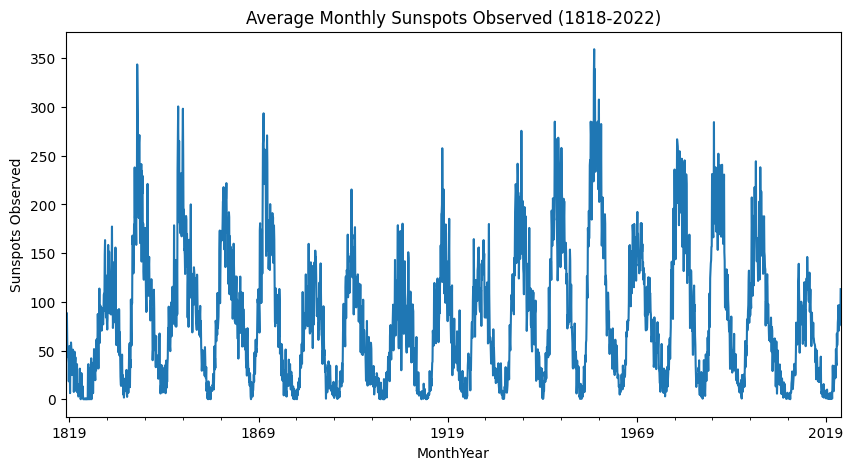

In [26]:
# stationarity
av_monthly_sunspots.plot(figsize=(10,5))
plt.title('Average Monthly Sunspots Observed (1818-2022)')
plt.xlabel('MonthYear')
plt.ylabel('Sunspots Observed');

> H0: The Series is non-stationary
>
> H1: The Series is stationary
>
> alpha = 0.05

In [27]:
# ADFuller Test
stat, pval = adfuller(av_monthly_sunspots)[:2]
stat, pval

(-9.720023042852699, 9.599130204913231e-17)

In [28]:
# returns the number of differencing using a specified test
ndiffs(av_monthly_sunspots, test='kpss')

0

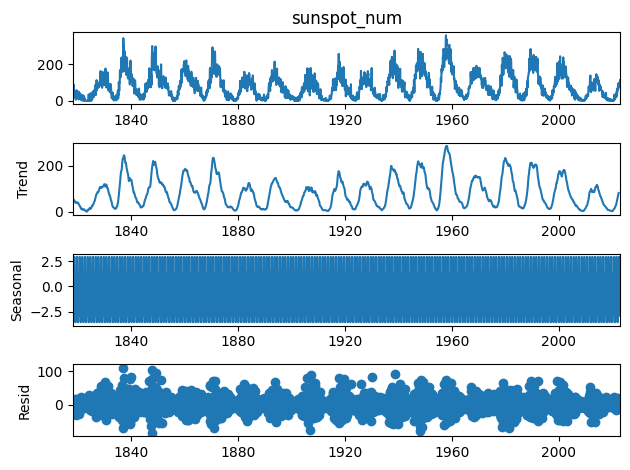

In [29]:
ax = seasonal_decompose(av_monthly_sunspots).plot()

- We see that the average monthly number of sunspots is stationary
- Zero differencing was returned by the KPSS test indicating that no-differencing should be applied
- The seasonal decompose plot also shows us that there is neither any trend or seasonality in the data

__AutoCorrelation and Partial Autocorrelation Plots__

Autocorrelation tells us the relationship between a time point and the time point after it. A time point may also be related to time points far away from it, but it is unsure if this correlation is because of the time points connecting them rather than the inherent contribution of that time point far away to the forecast. To overcome this problem, partial autocorrelation is used to find the relationship between a time point and n-timepoints by removing the effect of the time points in between. 

Now, we will plot the autocorrelation and partial autocorrelation plots for our data to understand lags which may be informative in forecasting.
An ARIMA model is composed of three orders: p,d,q, where the p indicates the number of autoregressive values that add information to forecasting the next value while the q indicates the number of moving averages. Autoregression is a type of regression of a variable against itself. The Autoregressive model uses a linear combination of past values of the variable to forecast the next value while a moving average model uses past forecast errors in a regression-like model to forecast the next value. 

The Autocorrelation plot enables us to choose the number of autoregressions (lags) of order _p_ while the partial autocorrelation plot enables us to choose the number of past forecast errors of order q.

---

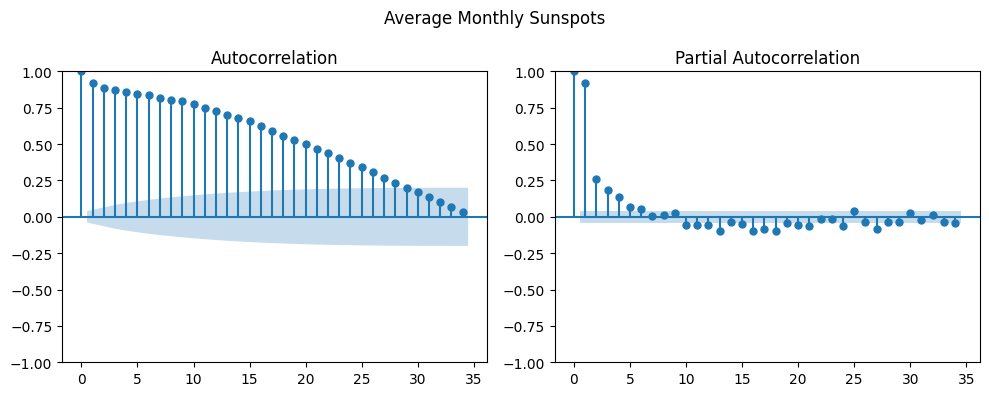

In [30]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_acf(av_monthly_sunspots,ax=ax[0])
plot_pacf(av_monthly_sunspots,ax=ax[1], method='ywm')
plt.suptitle('Average Monthly Sunspots', fontsize=12)
plt.tight_layout()
plt.show()

- From the ACF and PACF plots, we see that the monthly sunspots follow both an Autoregressive and moving average model. 
- From ACF, the autocorrelation begins to decrease as the number of lags increase.
- From PACF, the correlation between one lag with the other begins to decrease up to the 4th value in the series

To select the optimal p,d,q model, we will automatically do it using the AutoARIMA model from _pmdarima_ library

##### Model Development and Evaluation

In this part, we will split the average daily number of sunspots observed per month of every year. We will use the average daily sunspots observed in 2022 to evaluate the model's performance.

We will select the p,d,q values automatically

In [31]:
def mean_squared_error(y, preds):
    return np.mean((y-preds)**2)

def mean_absolute_error(y, preds):
    return np.mean(np.abs(y-preds))

def eval_metrics(y, ypreds):
    rmse = np.sqrt(mean_squared_error(y, ypreds))
    mae = mean_absolute_error(y, ypreds)
    print(f'MAE: {mae:.4f}\tRMSE: {rmse:.4f}')

In [32]:
train = av_monthly_sunspots[av_monthly_sunspots.index < '2022-01-31']
test = av_monthly_sunspots[av_monthly_sunspots.index >= '2022-01-31']

In [33]:
train.shape, test.shape

((2448,), (12,))

___Model Development (Forecasting)___

In [34]:
model1 = auto_arima(train, seasonal=False, stationary=True, stepwise=False, maxiter=100)

In [35]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2448
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -11280.412
Date:                Fri, 20 Jan 2023   AIC                          22574.824
Time:                        22:19:31   BIC                          22615.445
Sample:                    01-31-1818   HQIC                         22589.587
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1319      0.018      7.133      0.000       0.096       0.168
ar.L1          2.3486      0.023    103.157      0.000       2.304       2.393
ar.L2         -1.7125      0.045    -37.768      0.0

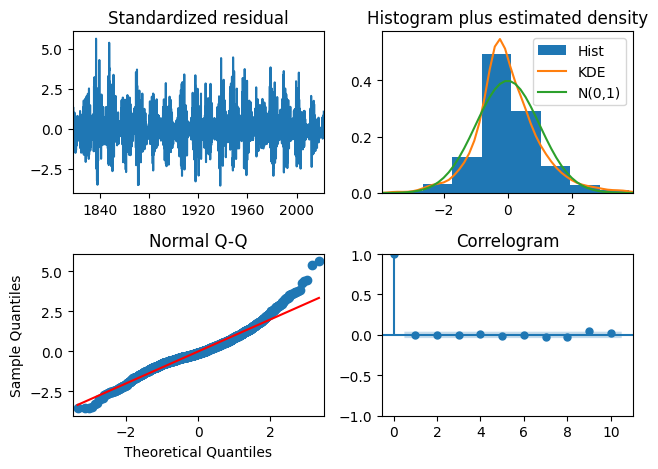

In [36]:
model1.plot_diagnostics()
plt.tight_layout()
plt.show()

- From the model parameters, we see that the optimal p,d,q orders with least error is 3,0,2.
- We see that coefficients are statistically significant at 5% significance level.
- The model predictions for samples in the train data resembles a normal distribution with skewness of 0.57 with deviations at the end of the distribution (from the Normal Q-Q plot)

___Model Evaluation___

In [37]:
# Evaluation on train data
eval_metrics(train, model1.fittedvalues())

MAE: 17.6986	RMSE: 24.2579


In [38]:
test_preds, conf_int  = model1.predict(len(test), return_conf_int=True)
conf_int = pd.DataFrame(conf_int, index=test_preds.index, columns=['lower', 'upper'])

In [39]:
# evaluation on test data
eval_metrics(test, test_preds)

MAE: 12.9170	RMSE: 15.9218


- The model seems not be doing badly in its predictions. 
- On average, the absolute difference between the actual and predicted values, given by the MAE, is about 13 sunspots while its predictions deviate from each other, given by the RMSE, is about 16 on average.

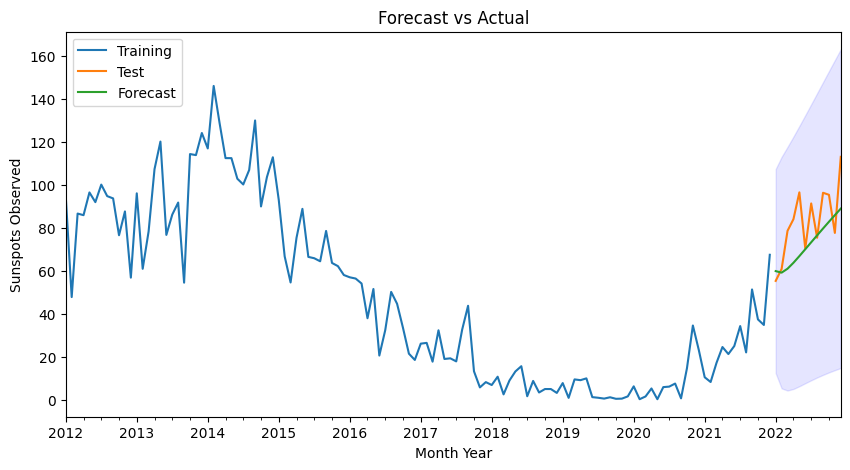

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
train[-120:].plot(ax=ax, label='Training')
test.plot(ax=ax, label='Test')
test_preds.plot(ax=ax, label='Forecast')
ax.fill_between(conf_int.index, y1=conf_int.lower, y2=conf_int.upper, color='b', alpha=.1)
ax.legend(loc='upper left')
ax.set(title='Forecast vs Actual', ylabel='Sunspots Observed', xlabel='Month Year');

___Forecasting average monthly sunspots to be observed in 2023___

In [41]:
model1 = auto_arima(av_monthly_sunspots, seasonal=False, stationary=True, stepwise=False, maxiter=100)

In [42]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2460
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -11331.884
Date:                Fri, 20 Jan 2023   AIC                          22677.768
Time:                        22:20:44   BIC                          22718.424
Sample:                    01-31-1818   HQIC                         22692.540
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1324      0.018      7.211      0.000       0.096       0.168
ar.L1          2.3476      0.023    103.424      0.000       2.303       2.392
ar.L2         -1.7103      0.045    -37.837      0.0

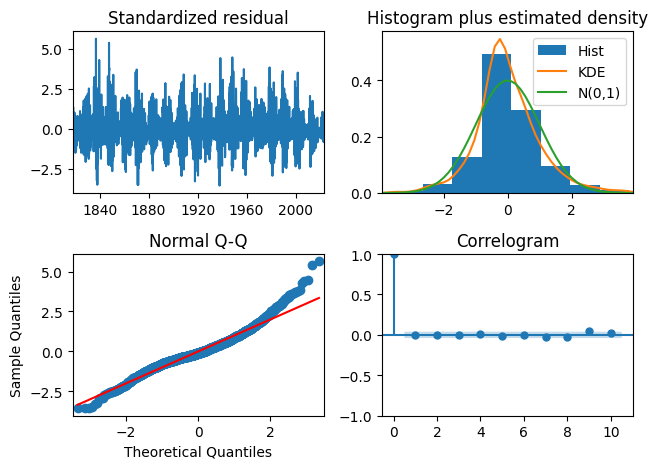

In [43]:
model1.plot_diagnostics()
plt.tight_layout()

In [44]:
# evaluating 
eval_metrics(av_monthly_sunspots, model1.fittedvalues())

MAE: 17.6788	RMSE: 24.2203


In [45]:
# forecasting for 2023
forecast, conf_int = model1.predict(12, return_conf_int=True)

conf_int = pd.DataFrame(conf_int, index=forecast.index, columns=['lower', 'upper'])

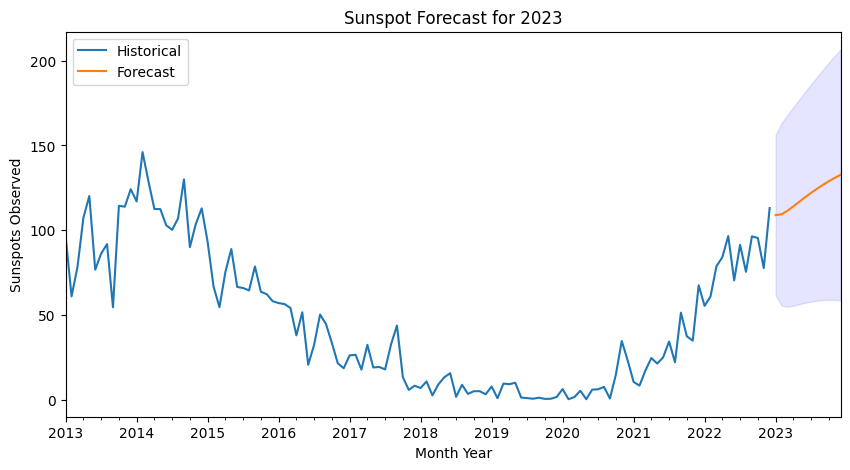

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
av_monthly_sunspots[-120:].plot(ax=ax, label='Historical')
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(conf_int.index, y1=conf_int.lower, y2=conf_int.upper, color='b', alpha=.1)
ax.legend(loc='upper left')
ax.set(title='Sunspot Forecast for 2023', ylabel='Sunspots Observed', xlabel='Month Year');

- Our model forecasts that the average daily number of sunspots to be observed, per month, in 2023 will increase. This makes sense since, the last solar cycle ended in 2019 and a new cycle begun from 2020

---

#### Yearly sunspots

Next, we will try to forecast the average monthly sunspots to be observed per year in the next 5 years. We will repeat the steps in the previous section

In [47]:
# ADFuller Test
stat, pval = adfuller(av_yearly_sunspots)[:2]
stat, pval

(-2.4955836887520406, 0.1165525621184536)

In [48]:
# returns the number of differencing using a specified test
ndiffs(av_yearly_sunspots, test='kpss')

0

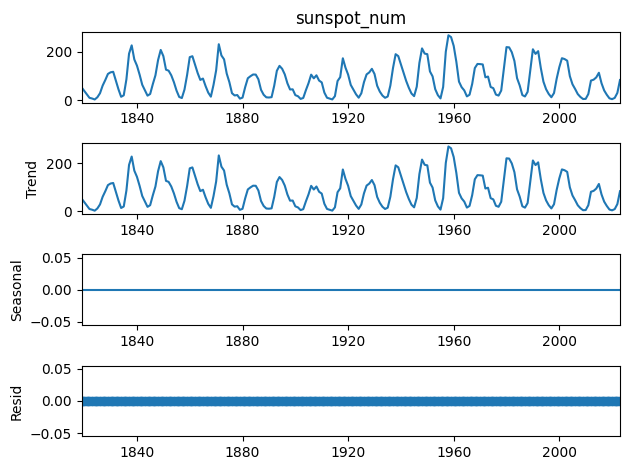

In [49]:
ax = seasonal_decompose(av_yearly_sunspots).plot()

- The ADFuller test returns that the data is non-stationary (pvalue > 0.05), however, using the kpss test to check the number of difference orders to apply, we see that no-differencing is to be applied. 
- Just like in the monthly data, there is no seasonality or trend in our data

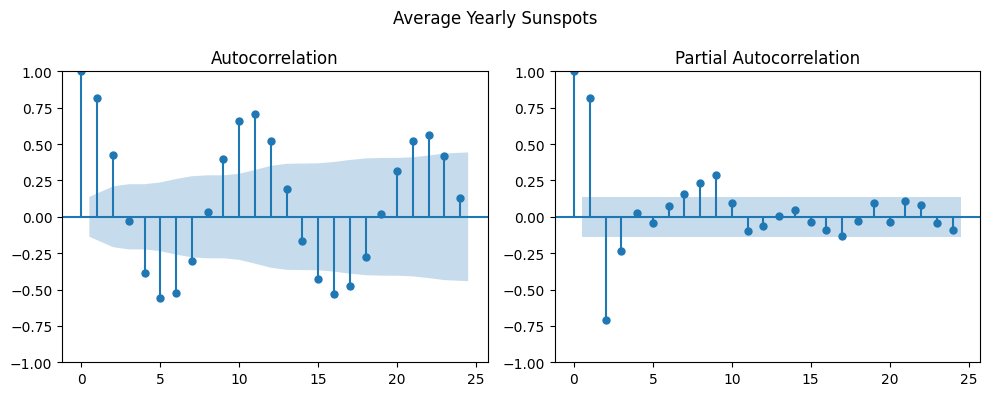

In [50]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_acf(av_yearly_sunspots,ax=ax[0])
plot_pacf(av_yearly_sunspots,ax=ax[1], method='ywm')
plt.suptitle('Average Yearly Sunspots', fontsize=12)
plt.tight_layout()
plt.show()

- We see from the ACF plot that there's a cyclical pattern in the yearly average sunspots.
- We also see that between the 10th and 11th year, the cycle seems to peak at those times

___Model Development (Forecasting)___

In [51]:
# using data for the last 5 years as test and others preceding them for training
train = av_yearly_sunspots[av_yearly_sunspots.index < '2013-01-31']
test = av_yearly_sunspots[av_yearly_sunspots.index >= '2013-01-31']

In [52]:
train.shape, test.shape

((195,), (10,))

In [53]:
model1 = auto_arima(train, seasonal=False, stationary=False, stepwise=False)

In [54]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -903.131
Date:                Fri, 20 Jan 2023   AIC                           1818.261
Time:                        22:21:22   BIC                           1837.899
Sample:                    12-31-1818   HQIC                          1826.213
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6191      0.029     90.040      0.000       2.562       2.676
ar.L2         -2.5653      0.051    -50.713      0.000      -2.664      -2.466
ar.L3          0.9430      0.024     40.017      0.0

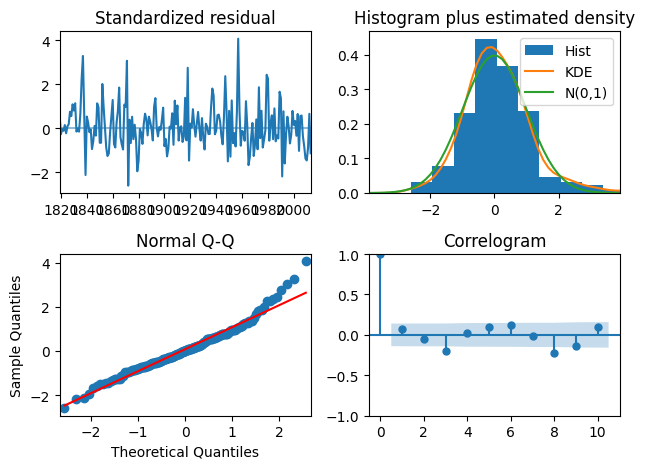

In [55]:
model1.plot_diagnostics()
plt.tight_layout();

- From the model parameters, we see that the optimal p,d,q orders with least error is 3,0,2.
- We see that coefficients are statistically significant at 5% significance level.
- The model predictions for samples in the train data resembles a normal distribution with skewness of 0.66 with slight deviations at the end of the distribution (from the Normal Q-Q plot)

___Model Evaluation___

In [56]:
# Evaluation on train data
eval_metrics(train, model1.fittedvalues())

MAE: 18.6194	RMSE: 24.7802


In [57]:
test_preds, conf_int  = model1.predict(len(test), return_conf_int=True)
conf_int = pd.DataFrame(conf_int, index=test_preds.index, columns=['lower', 'upper'])

In [58]:
# evaluation on test data
eval_metrics(test, test_preds)

MAE: 14.9751	RMSE: 18.0323


- The model seems not be doing badly in its predictions. 
- On average, the absolute difference between the actual and predicted values, given by the MAE, is about 15 sunspots while its predictions deviate from each other, given by the RMSE, is about 18 on average.

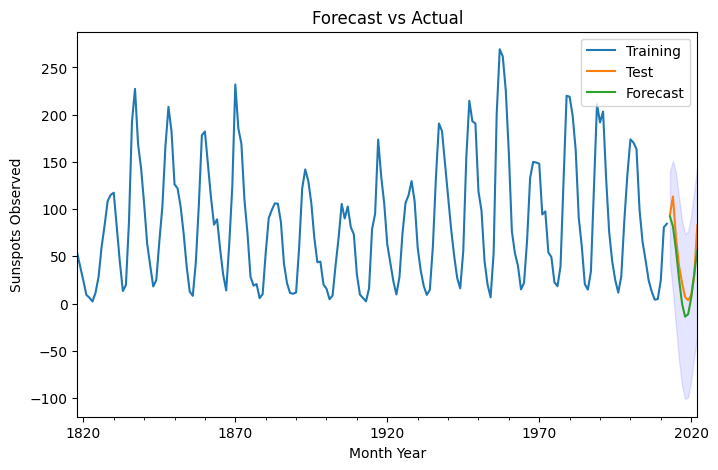

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
train.plot(ax=ax, label='Training')
test.plot(ax=ax, label='Test')
test_preds.plot(ax=ax, label='Forecast')
ax.fill_between(conf_int.index, y1=conf_int.lower, y2=conf_int.upper, color='b', alpha=.1)
ax.legend(loc='upper right')
ax.set(title='Forecast vs Actual', ylabel='Sunspots Observed', xlabel='Month Year');

- From the plot, we see that the model seems to model the movement of the cycle. However, the confidence of the predictions tend to decrease from the 3rd-4th year (lower confidence interval)

__Forecasting average yearly sunspots to be observed in the next 11 years__

In [60]:
model1 = auto_arima(av_yearly_sunspots, seasonal=False, stationary=False, stepwise=False, maxiter=100)

In [61]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -946.245
Date:                Fri, 20 Jan 2023   AIC                           1904.489
Time:                        22:21:46   BIC                           1924.427
Sample:                    12-31-1818   HQIC                          1912.554
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6193      0.029     91.894      0.000       2.563       2.675
ar.L2         -2.5649      0.050    -51.495      0.000      -2.663      -2.467
ar.L3          0.9428      0.023     40.540      0.0

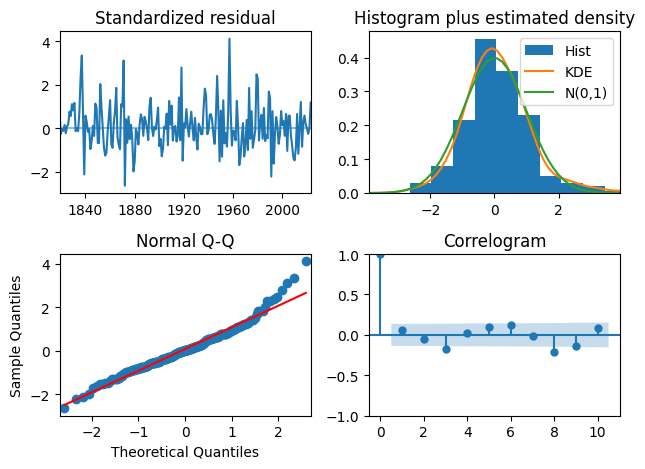

In [62]:
model1.plot_diagnostics()
plt.tight_layout()

In [63]:
# evaluating 
eval_metrics(av_yearly_sunspots, model1.fittedvalues())

MAE: 18.2473	RMSE: 24.4045


In [64]:
# forecasting from 2023-2033
forecast, conf_int = model1.predict(11, return_conf_int=True)

conf_int = pd.DataFrame(conf_int, index=forecast.index, columns=['lower', 'upper'])

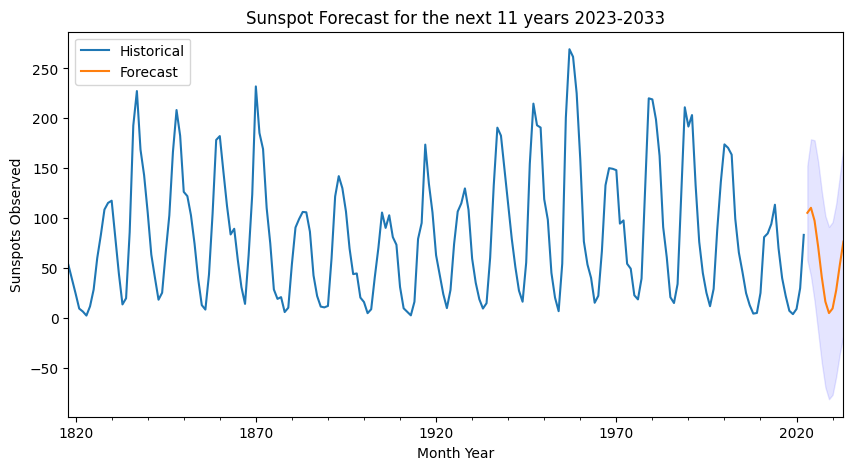

In [65]:
with plt.ion():
    fig, ax = plt.subplots(figsize=(10,5))
    av_yearly_sunspots.plot(ax=ax, label='Historical')
    forecast.plot(ax=ax, label='Forecast')
    ax.fill_between(conf_int.index, y1=conf_int.lower, y2=conf_int.upper, color='b', alpha=.1)
    ax.legend(loc='upper left')
    ax.set(title='Sunspot Forecast for the next 11 years 2023-2033', ylabel='Sunspots Observed', xlabel='Month Year');

- Our model seems to go with the cyclical nature of sunspots
- It forecasts that the current solar cycle reach its maximum peak in 2024 and then completes its cycle in 2030